In [1]:
import numpy as np
from scipy.linalg import eig, svd
import deeptime as dt
from deeptime.numeric import is_sorted, spd_inv_sqrt, schatten_norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyemma.msm import MSM,

In [51]:
def vamp(mod,  dim: int = 2, epsilon: float = 1e-15) -> float: 

    cmat = mod.count_model.count_matrix
    tmat = mod.transition_matrix
    
    # Empirical covariances
    cov0t = cmat
    cov00 = np.diag(cov0t.sum(axis=1))
    covtt = np.diag(cov0t.sum(axis=0))
    
    # Symmetrized tmat
    # reweight operator to empirical distribution
    C0t_re = cov00 @ tmat
    # symmetrized operator and SVD
    tmat_sym = np.linalg.multi_dot([spd_inv_sqrt(cov00, epsilon=epsilon, method='QR'), C0t_re,
                                 spd_inv_sqrt(covtt, epsilon=epsilon, method='QR')])

    # SVD
    U, singular_values, Vt = svd(tmat_sym, compute_uv=True)
    U = spd_inv_sqrt(cov00, epsilon=epsilon) @ U
    Vt = Vt @ spd_inv_sqrt(covtt, epsilon=epsilon)
    V = Vt.T
    
    
    # Sort by singular values
    sort_ix = np.argsort(singular_values)[::-1][:dim]  # indices to sort in descending order
    U = U[:, sort_ix]
    V = V[:, sort_ix]
    singular_values = singular_values[sort_ix]
    
    A = np.atleast_2d(spd_inv_sqrt(U.T.dot(cov00).dot(U), epsilon=epsilon))
    B = np.atleast_2d(U.T.dot(cov0t).dot(V))
    C = np.atleast_2d(spd_inv_sqrt(V.T.dot(covtt).dot(V), epsilon=epsilon))
    ABC = np.linalg.multi_dot([A, B, C])
    vamp1 = schatten_norm(ABC, 1) ** 1
    vamp2 = schatten_norm(ABC, 2) ** 2
    
    return vamp2, (mod.eigenvalues(2)**2).sum(), mod.timescales(1)[0]



def mod_from_c0t(C0t):
    cmod = dt.markov.TransitionCountModel(count_matrix=C0t)
    est = dt.markov.msm.MaximumLikelihoodMSM(lagtime=1, reversible=True)
    est.fit_from_counts(cmod)
    msm = est.fetch_model()  
    return msm, schatten_norm(C0t.T - C0t, 2) ** 2, None


In [47]:
T = np.array([[0.5, 0.34, 0.16], [0.28, 0.5, 0.22], [0.15, 0.25,0.6 ]])
N_obs = 20
N_trajs = 10000
mod = MSM(T)

dtrajs = [mod.simulate(N=N_obs) for _ in range(N_trajs)]
cmats = [dt.markov.TransitionCountEstimator(lagtime=1, count_mode='sliding').fit_fetch(dtraj).count_matrix 
        for dtraj in dtrajs]
cmat_ref = N_obs*np.diag(mod.stationary_distribution) @ T

In [50]:
scores = []
evs = []
ts = []
errs = []
deltas = []
iteration = []
masks = []
totals = []
for i in range(len(cmats)):

    msm, err, _ = mod_from_c0t(cmats[i])
    try:
        score, ev, t = vamp(msm)

    except: 
        score = np.nan
        ev = np.nan
        t = np.nan
        
    scores.append(score)
    evs.append(ev)
    ts.append(t)
    errs.append(err)
    iteration.append(i)
df = pd.DataFrame(dict(vamp2 = scores, evs = evs, timescales=ts, err=errs, 
                       iteration=iteration))

Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [2] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [2] due to error in estimation: Some row and corresponding column of the count matrix C have zero c

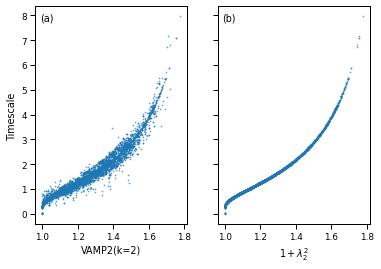

In [80]:
with sns.plotting_context('paper'):
    fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
    kws = dict(s=1, alpha=0.5, marker='o')
    axes[0].scatter(df['vamp2'], df['timescales'], **kws)
    axes[1].scatter(df['evs'], df['timescales'], **kws)
    
    axes[0].set_ylabel('Timescale')
    axes[0].set_xlabel('VAMP2(k=2)')
    axes[1].set_xlabel(r'$1+\lambda_{2}^{2}$')
    for i, ax in enumerate(axes.flatten()): 
        ax.annotate(text=['(a)', '(b)'][i], xy=(0.03, 0.97), xycoords='axes fraction', ha='left',va='top')
    plt.savefig('timescale_vs_vamp_vs_evs.pdf', bbox_inches='tight')